In [9]:
# EDA
import json # to import jsons
import pandas as pd # to manipulate datasets
import numpy as np # to perform numerical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting nicer
from scipy.stats import gamma
from matplotlib.ticker import FuncFormatter, MultipleLocator # to format the tickers of plots
import yaml # for importing a yaml file
import os

# modeling
from ultralytics import YOLO
from sklearn.model_selection import train_test_split, RepeatedKFold # for splitting between train and test and cv
from sklearn.metrics import mean_squared_error # for evaluating the model
from sklearn.linear_model import RidgeCV # for modeling
from sklearn.linear_model import Ridge # for modeling
from sklearn.utils import resample # Bootstrap to estimate p-values
import statsmodels.api as sm
import joblib
from sklearn.ensemble import GradientBoostingRegressor
import pickle

In [2]:
# Project Colors
color1= "#62b6cb"
color2= "#fb8500"
color3= "#023047"
color4= "#FFB703"

In [5]:
os.getcwd()

'C:\\Users\\daniq\\PycharmProjects\\project-danielteresa-API'

In [24]:
current_directory = os.getcwd()
last_folder = os.path.basename(current_directory)
    
if last_folder != "project-danielteresa-API":
    while last_folder != "project-danielteresa-API":
        parent_directory = os.path.dirname(current_directory)
        last_folder = os.path.basename(parent_directory)

        os.chdir(parent_directory)
        print(f"Changed directory to: {parent_directory}")
else:
    print("Already in the project root directory.")

Already in the project root directory.


In [50]:
# Define the file path
file_path = os.path.join('Others/df_total.csv')

# Check if the file exists
if os.path.exists(file_path):
    # Load the DataFrame from the CSV file
    df_total = pd.read_csv(file_path)
    print(f"DataFrame loaded from {file_path}")
else:

    # Save the DataFrame to the CSV file
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    df_total.to_csv(file_path, index=False)
    print(f"DataFrame saved to {file_path}")

# Display the DataFrame
print(df_total.head())

DataFrame loaded from Others/df_total.csv
        brand    model veh_age_range workshop_quality   counties damage_type  \
0      Toyota  Corolla           Old             High       Cork    mis_lost   
1      Toyota     C-HR         Newer              Low     Dublin    mis_lost   
2      Toyota    Yaris        Middle           Medium  Tipperary    mis_lost   
3  Volkswagen     Golf        Middle           Medium      Meath    mis_lost   
4  Volkswagen     Polo        Middle             High      Clare    mis_lost   

   repair_cost  labour_cost  total_cost  
0       104.67       101.80      206.47  
1       264.60        40.39      304.99  
2        91.23        47.51      138.74  
3       317.70        52.32      370.02  
4       178.53        91.11      269.64  


In [51]:
seed=123
np.random.seed(seed)

In [52]:
# we shuffle it
df_total_shuffled = df_total.sample(frac=1).reset_index(drop=True)
df_total_shuffled = df_total_shuffled.drop(['repair_cost', 'labour_cost'], axis=1)

In [53]:
# groups
group1 = ["Kildare", "Dublin"]
group2 = ["Meath", "Cork", "Westmeath", "Laois", "Galway", "Kilkenny", "Limerick", "Clare"]

# we change the groupìng
df_total_shuffled1 = df_total_shuffled.copy()
df_total_shuffled1['counties'] = df_total_shuffled['counties'].apply(lambda county:
                                               "group1" if county in group1
                                               else "group2" if county in group2
                                               else "group3")

#we check the results
print(df_total_shuffled1.groupby("counties").agg(
    total=("counties", 'count'),
    av_total_cost=("total_cost", "mean")
).reset_index().round(0))

  counties   total  av_total_cost
0   group1  266938          388.0
1   group2  264244          371.0
2   group3  278818          354.0


In [54]:
# Assuming df_total_shuffled1 is your DataFrame
X = df_total_shuffled1.drop('total_cost', axis=1)
y = df_total_shuffled1['total_cost']

# Transform categorical variables to dummy variables
cat_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Remove specified variables
#variables_to_remove = ['brand_Volkswagen', 'model_Golf', 'model_Polo', 'model_Tiguan']
#X = X.drop(columns=variables_to_remove)

# Convert bool columns to float64
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype('float64')

# Add a constant term for the intercept
X = sm.add_constant(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [56]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=5, random_state=seed)
#gb_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=seed)

In [57]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, random_state=123)

In [59]:
# Save the trained model to a file
with open('./Models/cost_model.pkl', 'wb') as file:
    pickle.dump(gb_model, file)

In [60]:
# Load the model from the file
with open('./Models/cost_model.pkl', 'rb') as file:
    cost_model_loaded = pickle.load(file)

# Now you can use gb_model to make predictions
predictions = cost_model_loaded.predict(X_test)

In [61]:
predictions

array([     403.04,      283.53,      729.15, ...,      673.17,      399.76,      399.76])

In [9]:
# Path to save/load the model
model_path = "./Models/cost_model.pkl"

# Fit the GLM with Gamma family and log link if it is not saved
if os.path.exists(model_path):
    print("Loading existing model...")
    gb_model = joblib.load(model_path)
else:
    print("Training new model...")
    try:
        gb_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=seed)
        gb_model.fit(X_train, y_train)
        # Save the model
        joblib.dump(gb_model, model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print("Error fitting the model:", e)
        raise e

Training new model...
Model saved to ./Models/cost_model.pkl


In [62]:
# Predict on training and test sets
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Evaluate the model
train_mse_gb = mean_squared_error(y_train, y_train_pred_gb)
test_mse_gb = mean_squared_error(y_test, y_test_pred_gb)

print(f'Training MSE (Gradient Boosting): {train_mse_gb}')
print(f'Test MSE (Gradient Boosting): {test_mse_gb}')

Training MSE (Gradient Boosting): 31308.798981540174
Test MSE (Gradient Boosting): 31484.037042832733


In [64]:
# Create a DataFrame with the test data and predictions
test_df = pd.DataFrame(X_test, columns=X.columns)
test_df['total_cost'] = y_test
test_df['total_cost_pred'] = y_test_pred_gb

# Sort the DataFrame by the actual response variable
test_df = test_df.sort_values(by='total_cost').reset_index(drop=True)

# Partition the DataFrame into 10 folds
test_df['fold'] = pd.qcut(test_df.index, 10, labels=False)

# Calculate the observed and predicted mean response variable for each fold
summary_table = test_df.groupby('fold').agg(
    total=('total_cost', 'size'),
    total_cost_mean=('total_cost', 'mean'),
    total_cost_pred_mean=('total_cost_pred', 'mean')
).reset_index()

AttributeError: 'NoneType' object has no attribute 'remove'

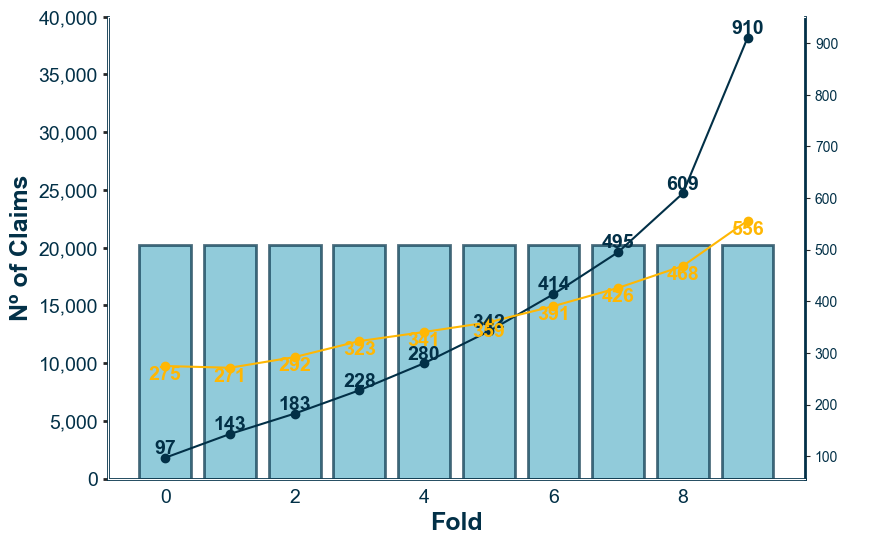

In [65]:
# VERSION 1

# Assuming your DataFrame and necessary data are already prepared as in your provided code
color1 = '#023047'  # Dark blue for the axes and observed line
color2 = '#FFB703'  # Yellowish for the predicted line

# Plot the results
fig, ax1 = plt.subplots(figsize=(9, 6))

# Bar plot for the total count in each fold with an outline
ax1.bar(summary_table['fold'], summary_table['total'], color='#62B6CB', alpha=0.7, edgecolor=color1, linewidth=2)
ax1.set_xlabel('Fold', fontname='Arial', fontsize=18, fontweight='bold', color=color1)
ax1.set_ylabel('Nº of Claims', fontname='Arial', fontsize=18, fontweight='bold', color=color1)
ax1.set_ylim(0, 40000)  # Set the y-axis limits
ax1.tick_params(axis='y', labelcolor=color1)
ax1.tick_params(axis='x', labelcolor=color1)

# Set x and y ticks to the specified font properties
ax1.tick_params(axis='x', labelsize=14, labelcolor=color1, width=2)
ax1.tick_params(axis='y', labelsize=14, labelcolor=color1, width=2)

# Format the y-axis labels with commas as thousands separators
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Line plot for the observed mean response variable
ax2 = ax1.twinx()
ax2.plot(summary_table['fold'], summary_table['total_cost_mean'], color=color1, marker='o', label='Observed Mean')
ax2.set_ylabel(' ', fontname='Arial', fontsize=18, fontweight='bold', color=color1)
ax2.tick_params(axis='y', labelcolor=color1)

# Annotate the observed mean response variable
for i in range(len(summary_table)):
    ax2.text(summary_table['fold'][i], summary_table['total_cost_mean'][i], 
             f"{summary_table['total_cost_mean'][i]:.0f}", color=color1, ha='center', va='bottom', 
             fontname='Arial', fontsize=14, fontweight='bold')

# Line plot for the predicted mean response variable
ax2.plot(summary_table['fold'], summary_table['total_cost_pred_mean'], color=color2, marker='o', label='Predicted Mean')

# Annotate the predicted mean response variable
for i in range(len(summary_table)):
    ax2.text(summary_table['fold'][i], summary_table['total_cost_pred_mean'][i], 
             f"{summary_table['total_cost_pred_mean'][i]:.0f}", color=color2, ha='center', va='top', 
             fontname='Arial', fontsize=14, fontweight='bold')

# Remove the grid lines
ax1.grid(False)
ax2.grid(False)

# Remove top spine and customize the others
sns.despine(ax=ax1, top=True, right=False, left=False, bottom=False)
ax1.spines['bottom'].set_color(color1)
ax1.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color1)

# Set the color and thickness of the spines
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)

# Set background to white
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Remove the legend
ax2.get_legend().remove()

# Remove the title and show the plot
fig.tight_layout()
plt.show()

In [43]:
# Create a DataFrame with the test data and predictions
test_df = pd.DataFrame(X_test, columns=X.columns)
test_df['total_cost'] = y_test
test_df['total_cost_pred'] = y_test_pred_gb

# Sort the DataFrame by the actual response variable
test_df = test_df.sort_values(by='total_cost').reset_index(drop=True)

# Partition the DataFrame into 30 folds
test_df['fold'] = pd.qcut(test_df.index, 30, labels=False)

# Calculate the observed and predicted mean response variable for each fold
summary_table = test_df.groupby('fold').agg(
    total=('total_cost', 'size'),
    total_cost_mean=('total_cost', 'mean'),
    total_cost_pred_mean=('total_cost_pred', 'mean')
).reset_index()


AttributeError: 'NoneType' object has no attribute 'remove'

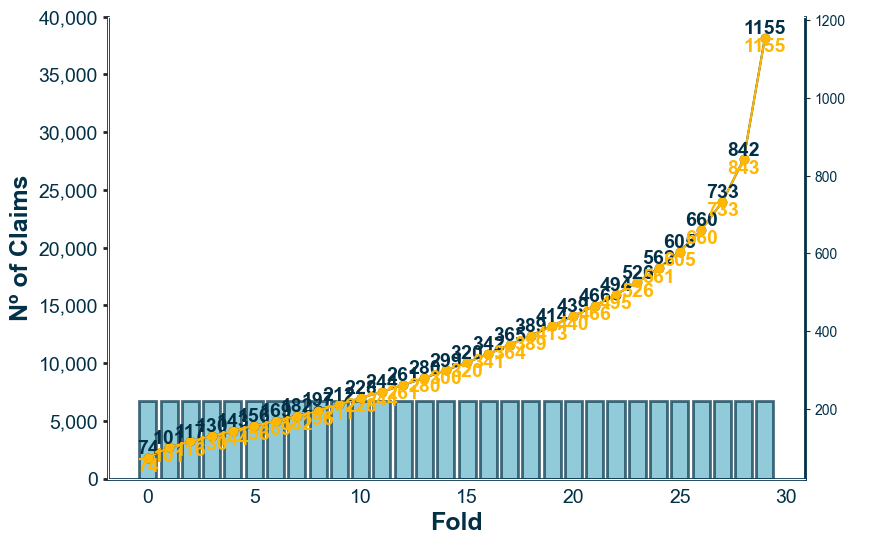

In [44]:
# VERSION 2

# Assuming your DataFrame and necessary data are already prepared as in your provided code
color1 = '#023047'  # Dark blue for the axes and observed line
color2 = '#FFB703'  # Yellowish for the predicted line

# Plot the results
fig, ax1 = plt.subplots(figsize=(9, 6))

# Bar plot for the total count in each fold with an outline
ax1.bar(summary_table['fold'], summary_table['total'], color='#62B6CB', alpha=0.7, edgecolor=color1, linewidth=2)
ax1.set_xlabel('Fold', fontname='Arial', fontsize=18, fontweight='bold', color=color1)
ax1.set_ylabel('Nº of Claims', fontname='Arial', fontsize=18, fontweight='bold', color=color1)
ax1.set_ylim(0, 40000)  # Set the y-axis limits
ax1.tick_params(axis='y', labelcolor=color1)
ax1.tick_params(axis='x', labelcolor=color1)

# Set x and y ticks to the specified font properties
ax1.tick_params(axis='x', labelsize=14, labelcolor=color1, width=2)
ax1.tick_params(axis='y', labelsize=14, labelcolor=color1, width=2)

# Format the y-axis labels with commas as thousands separators
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Line plot for the observed mean response variable
ax2 = ax1.twinx()
ax2.plot(summary_table['fold'], summary_table['total_cost_mean'], color=color1, marker='o', label='Observed Mean')
ax2.set_ylabel(' ', fontname='Arial', fontsize=18, fontweight='bold', color=color1)
ax2.tick_params(axis='y', labelcolor=color1)

# Annotate the observed mean response variable
for i in range(len(summary_table)):
    ax2.text(summary_table['fold'][i], summary_table['total_cost_mean'][i], 
             f"{summary_table['total_cost_mean'][i]:.0f}", color=color1, ha='center', va='bottom', 
             fontname='Arial', fontsize=14, fontweight='bold')

# Line plot for the predicted mean response variable
ax2.plot(summary_table['fold'], summary_table['total_cost_pred_mean'], color=color2, marker='o', label='Predicted Mean')

# Annotate the predicted mean response variable
for i in range(len(summary_table)):
    ax2.text(summary_table['fold'][i], summary_table['total_cost_pred_mean'][i], 
             f"{summary_table['total_cost_pred_mean'][i]:.0f}", color=color2, ha='center', va='top', 
             fontname='Arial', fontsize=14, fontweight='bold')

# Remove the grid lines
ax1.grid(False)
ax2.grid(False)

# Remove top spine and customize the others
sns.despine(ax=ax1, top=True, right=False, left=False, bottom=False)
ax1.spines['bottom'].set_color(color1)
ax1.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color1)

# Set the color and thickness of the spines
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)

# Set background to white
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Remove the legend
ax2.get_legend().remove()

# Remove the title and show the plot
fig.tight_layout()
plt.show()

In [10]:
os.getcwd()

'C:\\Users\\daniq\\PycharmProjects\\project-danielteresa-API'

In [66]:
#  charge models and obtain the prediciton of the photo
path_upload = 'C:\\Users\\daniq\\PycharmProjects\\project-danielteresa-API\\API\\uploads'
picture_name=os.listdir(path_upload)[0]
full_path= os.path.join(path_upload,picture_name)
# we import model
yolo_model = YOLO("./Models/yolo_model.pt")


# we predict the image
results = yolo_model.predict(full_path,conf=0.25)

# we save the image
path_output = os.path.join(path_upload, 'pred_'+picture_name)
results[0].save(filename=path_output)


image 1/1 C:\Users\daniq\PycharmProjects\project-danielteresa-API\API\uploads\mix2.jpg: 384x640 1 met_scratch, 1 mis_punct, 282.1ms
Speed: 0.0ms preprocess, 282.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


'C:\\Users\\daniq\\PycharmProjects\\project-danielteresa-API\\API\\uploads\\pred_mix2.jpg'

In [67]:
buttom_workshop='Sandyford McCann Motor'


# Display the selected workshop
if buttom_workshop != "Select among available workshops":
    # workshop selection
    workshops={
    'Smithfield Autotech':'Low',
    'Sandyford McCann Motor':'Medium',
    'Mobile Mechanic':'High'
    }

    selected_workshop_qual = workshops[buttom_workshop]

    # we predict the cost of the claims
    case = pd.DataFrame({
    'const': [1],
    'brand_Volkswagen': [0],
    'model_Corolla': [0],
    'model_Golf': [0],
    'model_Polo': [0],
    'model_Tiguan': [0],
    'model_Yaris': [1],
    'veh_age_range_Newer': [1],
    'veh_age_range_Old': [0],
    'workshop_quality_Low': [0],
    'workshop_quality_Medium': [0],
    'counties_group2': [0],
    'counties_group3': [0],
    'damage_type_met_dent_medium': [0],
    'damage_type_met_dent_minor': [0],
    'damage_type_met_dent_severe': [0],
    'damage_type_met_tear': [0],
    'damage_type_mis_lamp': [0],
    'damage_type_mis_lost': [0],
    'damage_type_mis_punct': [0]
    })

    # Adjust case DataFrame based on selected_workshop_qual
    if selected_workshop_qual == 'High':
        case['workshop_quality_Low'] = [0]
        case['workshop_quality_Medium'] = [0]
    elif selected_workshop_qual == 'Medium':
        case['workshop_quality_Low'] = [0]
        case['workshop_quality_Medium'] = [1]
    elif selected_workshop_qual == 'Low':
        case['workshop_quality_Low'] = [1]
        case['workshop_quality_Medium'] = [0]

    damage_types = [results[0].names[int(cls)] for cls in results[0].boxes.cpu().numpy().cls]

    # Function to generate the complete_case DataFrame
    def generate_complete_case(case, damage_types):
        complete_case = pd.DataFrame()

        for damage_type in damage_types:
            temp_case = case.copy()

            # Set the corresponding damage type to 1
            damage_column = f'damage_type_{damage_type}'
            if damage_column in temp_case.columns:
                temp_case[damage_column] = [1]

            # Append this row to the complete_case DataFrame
            complete_case = pd.concat([complete_case, temp_case], ignore_index=True)

        return complete_case


    # Generate the complete_case DataFrame
    complete_case = generate_complete_case(case, damage_types)

In [15]:
complete_case

,const,brand_Volkswagen,model_Corolla,model_Golf,model_Polo,model_Tiguan,model_Yaris,veh_age_range_Newer,veh_age_range_Old,workshop_quality_Low,workshop_quality_Medium,counties_group2,counties_group3,damage_type_met_dent_medium,damage_type_met_dent_minor,damage_type_met_dent_severe,damage_type_met_tear,damage_type_mis_lamp,damage_type_mis_lost,damage_type_mis_punct
0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1


In [68]:
# Load the model from the file
with open('./Models/cost_model.pkl', 'rb') as file:
    cost_model_loaded = pickle.load(file)

In [69]:
# Make predictions
predictions = cost_model_loaded.predict(complete_case)

In [71]:
# dataframe with the predictions
cost_predictions= pd.DataFrame({'Damages': damage_types,'Cost Estimates': cost_model_loaded.predict(complete_case).round(0)
    })
    
    
    
# Calculate the total cost as the sum of all 'Cost Estimates'
total_cost = cost_predictions['Cost Estimates'].sum()

# Format total_cost as a string with no decimals and a comma as a thousands separator
formatted_total_cost = f"{total_cost:,.0f}"

In [72]:
formatted_total_cost

'734'